# Getting Started | U-Net with OpenPack Dataset (IMU)

## [0] Inital Setup

### 0-1: Download Code and Install `openpack-torch` 
NOTE: You can also install `openpack-torch` from PyPI with `pip install openpack-torch`.

In [ ]:
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [1]:
! cd /content/openpack-torch/ && pip install .

Processing /content/openpack-torch
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openpack-torch: filename=openpack_torch-0.3.0-py3-none-any.whl size=19597 sha256=a8289b6a872c4736e3a21c49c83db1fcc18276e946592c7f47b4eff739eb91d9
  Stored in directory: /root/.cache/pip/wheels/3c/41/d3/f3da9cc23f0fe3895867143cff021a2da847c6ed2c7f33f269
Successfully built openpack-torch
  Attempting uninstall: openpack-toolkit
    Found existing installation: openpack-toolkit 0.4.0
    Uninstalling openpack-toolkit-0.4.0:
      Successfully uninstalled openpack-toolkit-0.4.0
  Attempting uninstall: openpack-torch
    Found existing installation: openpack-torch 0.3.0
    Uninstalling openpack-torch-0.3.0:
      Successfully uninstalled openpack-torch-0.3.0


### 0-2: Download Dataset to  `/content/data`
- Souce (IMU data of U0102): TBA

In [2]:
! mkdir -p /content/data/datasets/
! optk-download -d /content/data/datasets -v v0.2.1 -s atr-qags,openpack-operations

INFO:openpack_toolkit.bin.download:Donwload OpenPack dataset from zenodo.
INFO:openpack_toolkit.bin.download: - dataset_dir : /content/data/datasets
INFO:openpack_toolkit.bin.download: - version     : v0.2.1
INFO:openpack_toolkit.bin.download: - streams     : ['atr-qags', 'openpack-operations']
INFO:openpack_toolkit.download._helpers:== [0/2] atr-qags ==
INFO:openpack_toolkit.download._helpers:[0/5] U0102
INFO:openpack_toolkit.download._helpers:  download https://zenodo.org/record/6811369/files/U0102__atr.zip?download=1 ...
INFO:openpack_toolkit.download._helpers:  unzip /content/data/datasets/openpack/v0.2.1/zenodo/U0102__atr.zip to /content/data/datasets/openpack/v0.2.1 ...
INFO:openpack_toolkit.download._helpers:  done!
INFO:openpack_toolkit.download._helpers:[1/5] U0103
INFO:openpack_toolkit.download._helpers:  download https://zenodo.org/record/6811369/files/U0103__atr.zip?download=1 ...
INFO:openpack_toolkit.download._helpers:  unzip /content/data/datasets/openpack/v0.2.1/zenodo/

In [3]:
! tree /content/data/datasets/openpack/v0.2.1

/content/data/datasets/openpack/v0.2.1
├── U0102
│   ├── annotation
│   │   └── openpack-operations
│   │       ├── S0100.csv
│   │       ├── S0200.csv
│   │       ├── S0300.csv
│   │       ├── S0400.csv
│   │       └── S0500.csv
│   ├── atr
│   │   ├── atr01
│   │   │   ├── S0100.csv
│   │   │   ├── S0200.csv
│   │   │   ├── S0300.csv
│   │   │   ├── S0400.csv
│   │   │   └── S0500.csv
│   │   ├── atr02
│   │   │   ├── S0100.csv
│   │   │   ├── S0200.csv
│   │   │   ├── S0300.csv
│   │   │   ├── S0400.csv
│   │   │   └── S0500.csv
│   │   ├── atr03
│   │   │   ├── S0100.csv
│   │   │   ├── S0200.csv
│   │   │   ├── S0300.csv
│   │   │   ├── S0400.csv
│   │   │   └── S0500.csv
│   │   └── atr04
│   │       ├── S0100.csv
│   │       ├── S0200.csv
│   │       ├── S0300.csv
│   │       ├── S0400.csv
│   │       └── S0500.csv
│   ├── kinect
│   │   └── 2d-kpt
│   │       └── mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2
│   │           └── single
│   │               ├── S0100.json

### 0-3: Import Modules

In [4]:
import os
import shutil
import logging
from pathlib import Path
from typing import Dict

import hydra
import numpy as np
import openpack_toolkit as optk
import openpack_torch as optorch
import pandas as pd
import pytorch_lightning as pl
import torch
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns
from hydra import initialize_config_dir, compose
from omegaconf import DictConfig, OmegaConf

from openpack_toolkit import OPENPACK_OPERATIONS
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

sns.set("notebook", "whitegrid")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0-4: Setup Logger

In [5]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2022-07-10 13:08:20 | INFO | __main__ | info
2022-07-10 13:08:20 | WARNING | __main__ | warning


### 0-5: Set Random Seed

In machine learning, a lot of random variables are generated and it affect to model's performance.
By resetting a random seed before each run, you can improve reproducibility. 

In [6]:
optorch.utils.reset_seed(seed=0)

2022-07-10 13:08:20 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


## [1] Load Config File

### 1-1: Overview of Config Files
Thare are a lot of parameters that are needed to train deep learning models. Managing these parameters is a laborious task.
Here are some useful tools to ease this burden. [hydra](https://hydra.cc/) is a framework for elegantly configurein complex application, and also you can use it to manage parameters.
To update default parameters, please update YAML files in [configs](https://github.com/open-pack/openpack-torch/tree/main/examples/unet/configs).
We will show you sime examples.

#### Ex.1: Change Training Parameters

For example, when you want to change default `batch_size`, edit [operation-segmentation.yaml](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/operation-segmentation.yaml) as follows.

```yaml
train:
  num_workers: 3
  batch_size: 128 # Updated (original value = 64)
  epochs: 100
```

#### Ex.2: Change Input Modality

An another example is to add IMU sensors at left&right arm (atr03, atr04).
You can change it by editing [atr-acc-wrists.yaml](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/dataset/stream/atr-acc-wrists.yaml)


```yaml
defaults:
  - atr-qags
  - _self_
name: atr-acc-wrists
super_stream: atr-qags
devices:
- atr01
- atr02
- atr03 # Add 
- atr04 # Add
acc: true
gyro: false
quat: false
```


Please refer to [openpack-toolkit/configs/dataset](https://github.com/open-pack/openpack-toolkit/tree/main/openpack_toolkit/configs/dataset) when you write a new dataset configuration.
We also recommend you to read through docs of [hydra](https://hydra.cc/) and [omegaconf](https://omegaconf.readthedocs.io/en/latest/structured_config.html) and this might help you a lot!

### 1-2: Register Configs to Hydra in `openpack-torch`
First, register OpenPaack official configs to hydra.

In [7]:
optorch.configs.register_configs()

### 1-3: Load Custom Configs
Load configuration files in [/content/openpack-torch/examples/unet/configs](https://github.com/open-pack/openpack-torch/blob/main/examples/unet/configs/operation-segmentation.yaml).
You may want to change some parameters frequently, such as learning rate. You can change them by adding entries to a list `overrides`. 

In [8]:
config_dir = Path("/content/openpack-torch/examples/unet/configs")
overrides = [
    "mode=train",
    "issue=I01-EXP1-V1-nb", # subdirectry for logging
    "debug=false", # Set true when you want to make submission file to submit to the Development Phase form.
    "datarootdir=/content/data", # data directory, dataset and logs are loaded from and stored to this directory.
    "hydra/job_logging=custom",
    "hydra/hydra_logging=disabled"
]

with initialize_config_dir(version_base=None, config_dir=str(config_dir)):
    cfg = compose(
        config_name="operation-segmentation.yaml",
        overrides=overrides,
    )

In [9]:
print(OmegaConf.to_yaml(cfg))

dataset:
  annotation:
    name: openpack-operations
    version: v3.2.1
    path:
      dir: ${path.openpack.rootdir}/${user.name}/annotation/${..name}
      fname: ${session}.csv
    file_format: null
    classes:
      classes:
      - id: 100
        name: Picking
        is_ignore: false
      - id: 200
        name: RelocateItemLabel
        is_ignore: false
      - id: 300
        name: AssembleBox
        is_ignore: false
      - id: 400
        name: InsertItems
        is_ignore: false
      - id: 500
        name: CloseBox
        is_ignore: false
      - id: 600
        name: AttachBoxLabel
        is_ignore: false
      - id: 700
        name: ScanLabel
        is_ignore: false
      - id: 800
        name: AttachShippingLabel
        is_ignore: false
      - id: 900
        name: PutOnRack
        is_ignore: false
      - id: 1000
        name: Fill-outOrder
        is_ignore: false
      - id: 8100
        name: 'Null'
        is_ignore: true
  stream:
    schema: ImuCon

## [2] Define Utilities (Pytorch Lightning Modules)

### 2-1: DataModule

Override `dataset_class` with `optorch.data.OpenPackBaseDataModule` to use IMU dataset.
When you implement custom dataset, set the dataset class to `dataset_class`. 
IMU dataset is defined in [here](https://github.com/open-pack/openpack-torch/blob/main/openpack_torch/data/datasets.py).

Paramters to initialize the dataset class should be prepared in `get_kwargs_form_datasets()` method.

`kwargs` that is 

The dataset class is initialized with`kwargs`, an output of `get_kwargs_form_datasets()`, as follows. 

```python
# https://github.com/open-pack/openpack-torch/blob/6c6933e24c7c3311e582ebf3aac1a659467be0fb/openpack_torch/data/datamodule.py#L91
self.op_train = self.dataset_class(self.cfg, split.train, **kwargs)
```


In [10]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    # 
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 2-2: Lightning Module

In the `init_model()` method, you can initialize your model.

In the `init_criterion()` method, you can register your custom loss function.
But make sure that ignore classes are excluded from evaluation process.
For `torch.nn.CrossEntropyLoss`, you can use `ignore_class` parameter.

In [11]:
class UNetLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        dstream_conf = self.cfg.dataset.stream
        in_ch = len(dstream_conf.devices) * 3

        # Edit here to use your custom model!
        model = optorch.models.imu.UNet(
            in_ch,
            len(OPENPACK_OPERATIONS),
            depth=cfg.model.depth,
        )
        return model
    
    
    def init_criterion(self, cfg: DictConfig):
        ignore_cls = [(i, c) for i, c in enumerate(cfg.dataset.annotation.classes.classes) if c.is_ignore]
        
        criterion = torch.nn.CrossEntropyLoss(
            ignore_index=ignore_cls[-1][0]
        )
        return criterion

    def training_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        return outputs


## [3] Train U-Net

### 3-1: Initialize U-Net Model and DataLoader.

In [12]:
device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg)
plmodel = UNetLM(cfg).to(dtype=torch.float, device=device)

2022-07-10 13:09:13 | INFO | torch.distributed.nn.jit.instantiator | Created a temporary directory at /tmp/tmpektj4hnl
2022-07-10 13:09:13 | INFO | torch.distributed.nn.jit.instantiator | Writing /tmp/tmpektj4hnl/_remote_module_non_sriptable.py


In [13]:
plmodel

UNetLM(
  (net): UNet(
    (inc): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoder): UNetEncoder(
      (conv_blocks): ModuleList(
        (0): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
            (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
          )
          (pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        )
        (1): DownBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3,

### 3-2: Initialize Trainer

In [14]:
# num_epoch = cfg.train.debug.epochs if cfg.debug else cfg.train.epochs
num_epoch = 50 # NOTE: Set epochs manually for debugging

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)

trainer = pl.Trainer(
    gpus=[0],
    max_epochs=num_epoch,
    logger=False,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=False,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3-3: Start training!

In [15]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

2022-07-10 13:09:16 | INFO | __main__ | Start training for 50 epochs.
2022-07-10 13:09:19 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:09:19 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:09:19 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:09:19 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False)
2022-07-10 13:09:19 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7fa73df00280>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7fa73df16220>}
2022-07-10 13:09:19 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-07-10 13:09:19 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
------------------

### 3-4: Plot Training Curve

Training logs are stored in `plmodel.log` (dict). Let's visualize training curves for training and validation set.

In [16]:
df = pd.concat([
    pd.DataFrame(plmodel.log["train"]),
    pd.DataFrame(plmodel.log["val"]),
],axis=1,)
df.index.name = "epoch"

In [17]:
df.head()

,train/loss,train/acc,val/loss,val/acc
epoch,,,,
0,2.439604,0.086812,2.380983,0.155422
1,2.350926,0.135012,2.391924,0.106913
2,2.276149,0.176851,2.390011,0.056924
3,2.210993,0.225909,2.357944,0.124014
4,2.160511,0.265095,2.298408,0.192046


Training Log

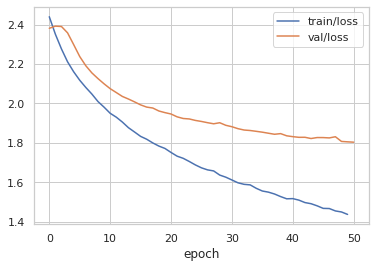

In [18]:
df[["train/loss", "val/loss"]].plot()
plt.show()

Test Log

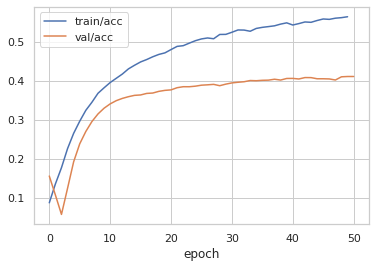

In [19]:
df[["train/acc", "val/acc"]].plot()
plt.show()

## [4] Test

Evaluation function is defined in `optk.codalab.eval_operation_segmentation_wrapper()`. This function takes dict as the 1st argument and prediction (`y`), groundtruth (`t_idx`; activity class index) and corresponding unixtime (`unixtime`) must be included in the dict object. Each sequence should be stored in the different entries with a key `{user}-{session}` (e.g., `U0107-S0100`). For the detail, please refere to the following examples.

```python
outputs = {
    "U0107-S0100": {
        "t_idx": [0, 0, ...], # groundtruth (class index)
        "y": [
            [
                [0., 0., ...],
                [0., 0., ...],
                [1., 1., ...],
            ],
        ], # prediction. shape=(B,N_CLASSES,T), dtype=float
        "unixtiume": [634885794000, 1634885794200, ...], # unixtime
    },
    "U0107-S0200": {
        "t_idx": [...], 
        "y": [...],
        "unixtiume": [...],
    },
    ...
}
```

### 4-1: Get prediction results for each sequences and build result dict.

In [20]:
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test


outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "t_idx": plmodel.test_results.get("t"),
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-07-10 13:11:56 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:11:56 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:11:56 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:11:56 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-07-10 13:11:56 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-07-10 13:11:56 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7fa73e385ac0>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7fa73e34a7c0>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7fa855d56f40>}
2022-07-10 13:11:56 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-07-10 13:11:56 | INFO | __main__ | test on U0106-S0100
2022-07-10 13:11:56 | WARNING | openpack_torch.data.datasets | No preprocessing is

### 4-2: Evaluate

In [21]:
# compute performance summary
df_summary = eval_operation_segmentation_wrapper(
    outputs, OPENPACK_OPERATIONS,
)

In [22]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
36,avg/macro,-1,0.452845,0.361604,0.344047,None,all
37,avg/weighted,-1,0.434059,0.390602,0.370761,None,all
38,Picking,100,0.285866,0.476950,0.357475,564,all
39,RelocateItemLabel,200,0.428363,0.626068,0.508681,936,all
40,AssembleBox,300,0.466472,0.307988,0.371014,1039,all
41,InsertItems,400,0.329939,0.328600,0.329268,493,all
42,CloseBox,500,0.343124,0.389985,0.365057,659,all
43,AttachBoxLabel,600,1.000000,0.009063,0.017964,331,all
44,ScanLabel,700,0.449749,0.527246,0.485424,679,all
45,AttachShippingLabel,800,0.398625,0.250540,0.307692,463,all


## 4-3: Visualize Model Output

The model's outputs can be transformed into probability by applying `softmax()` function.
Here, let's visualize confidence scores as heatmap.

NOTE: Evaluation is done in 1 Hz, but we visualize the output sample by sample.

In [23]:
def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)
    
    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3", 
    )
    ax0.plot(
        x, pred + 0.5, label="pred",
        linewidth=1, color="C1", alpha=0.5,
    )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)
    
    
    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


In [24]:
key = "U0106-S0500"

unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(18, 1800), t_idx=(18, 1800), y=(18, 11, 1800), y_softmax=(18, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


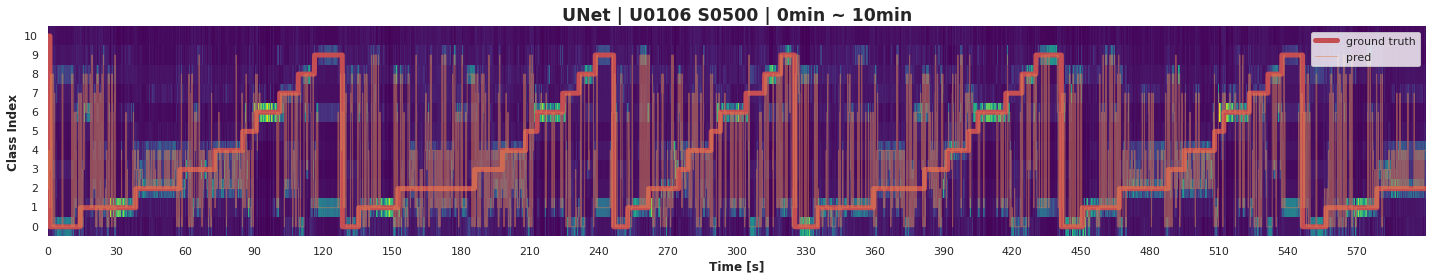

In [25]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

prob=(11, 14400) pred=(14400,), gt=(14400,)


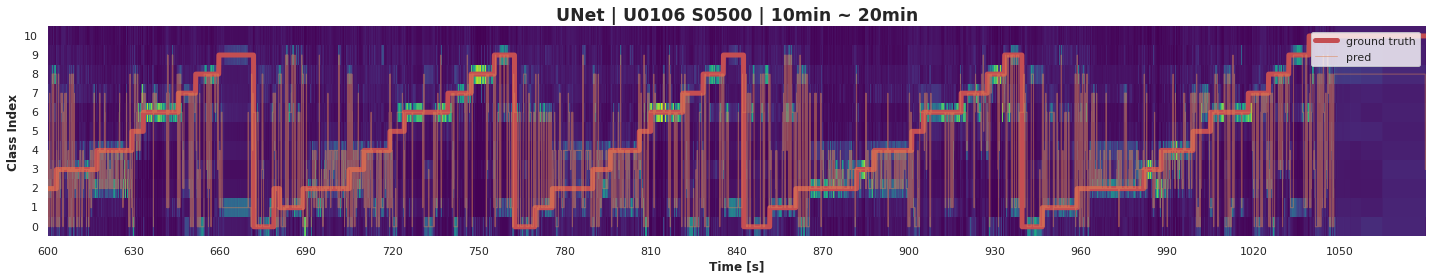

In [26]:
samples = (10, 20)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {user} {session}")
fig.show()

## [5] Submission

`optk.codalab.construct_submission_dict()` can be used to make submission files to codalab.
The parameter is almost the same as `optk.codalab.eval_operation_segmentation_wrapper()` (used for evaluation), but groundtruth filed (`t_idx`) is exclided.

### 5-1: Get prediction for test data.

NOTE: Data for submission is not available in OpenPack(v0.2.0).  Therefore use test set for debugging purpose.

In [29]:
datamodule.setup("submission")
dataloaders = datamodule.submission_dataloader()
split = cfg.dataset.split.submission

# # NOTE: data for submission is not available in OpenPack(v0.2.0).  Therefore use test set for debugging.
# datamodule.setup("test")
# dataloaders = datamodule.test_dataloader()
# split = cfg.dataset.split.test 

outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-07-10 13:19:16 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:19:16 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:19:16 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:19:16 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-07-10 13:19:16 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-07-10 13:19:16 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-07-10 13:19:16 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-07-10 13:19:16 | INFO | openpack_torch.data.datamodule | dataset[submission]: {'U0107-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7fa855995a30>, 'U0107-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7fa8558d95e0>, 'U0107-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7fa8558e12e0>, 'U0107-S0500': <openpack_torch.data.datasets.OpenP

### 5-2: Make submission zip file

In the `construct_submission_dict()`, following processing will be done.

- Convert a predcition tesor `y` (3D array of logits) into a 2d matrix of predicted class ids.
- Resample sequence into 1 Hz.
- Exclude the segments that is out of range for the evaluation protocol (i.e., unlabeled or null segments).

In the `make_submission_zipfile()`, following processing will be done.

- extract `prediction` and `unixtime` field 
- generate `submission.json` and `submission.zip` to `output_dir`.

In [30]:
output_dir = Path(".")

submission_dict = construct_submission_dict(
    outputs, OPENPACK_OPERATIONS)
make_submission_zipfile(submission_dict, output_dir)

2022-07-10 13:19:20 | INFO | openpack_toolkit.codalab.operation_segmentation.utils | write submission.json to submission.json
2022-07-10 13:19:20 | INFO | openpack_toolkit.codalab.operation_segmentation.utils | write submission.zip to submission.zip


### 5-3: Submit to codalab and get results!

Now, you got a submission zip file (`./submission.zip`).
Let's upload it in the competition site (codalab) and get your score!